In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVDpp, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

warnings.filterwarnings('ignore')

In [2]:
electronic_data = pd.read_csv('../b. Datasets/Electronics Rating.csv')

In [3]:
display(electronic_data.head(2))
display(electronic_data.tail(2))

,UserID,ItemID,Rating,Timestamp
0,ACFKCAG2XAE4R,B0001DQ5YG,5,1169337600
1,ASXP88VXB6ETF,B00020QJC6,4,1104105600


,UserID,ItemID,Rating,Timestamp
78642,A3JMYUXPG9NA3B,B000BQ7GW8,5,1381190400
78643,A9DN3XNVDVHLH,B000652SOK,5,1388016000


In [4]:
electronic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78644 entries, 0 to 78643
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     78644 non-null  object
 1   ItemID     78644 non-null  object
 2   Rating     78644 non-null  int64 
 3   Timestamp  78644 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


In [5]:
electronic_data.isna().sum()

UserID       0
ItemID       0
Rating       0
Timestamp    0
dtype: int64

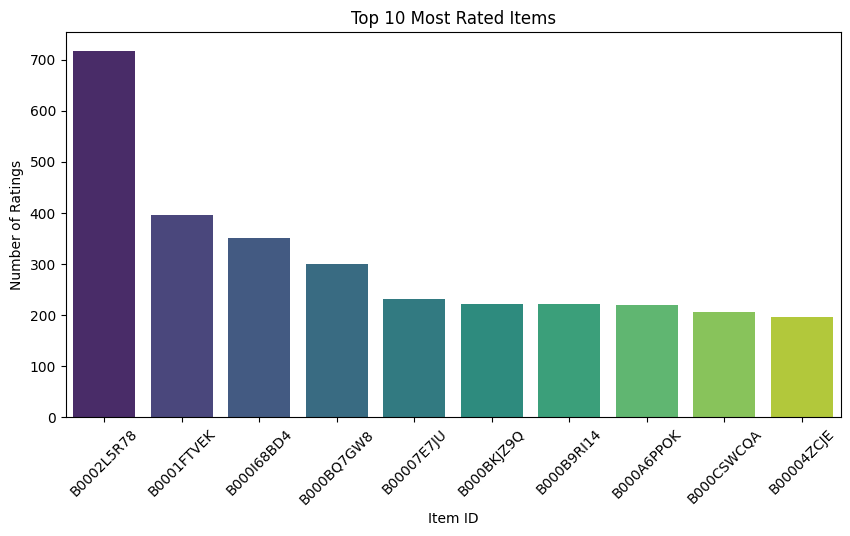

In [6]:
top_items = electronic_data['ItemID'].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_items.index, y=top_items.values, palette='viridis')
plt.xlabel("Item ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.title("Top 10 Most Rated Items")
plt.show()

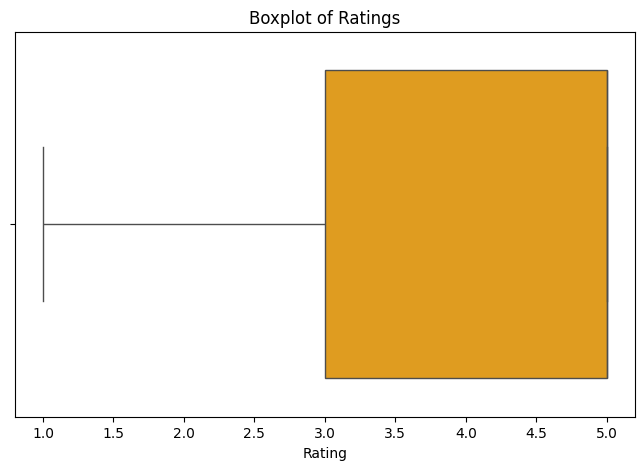

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=electronic_data['Rating'], color='orange')
plt.xlabel("Rating")
plt.title("Boxplot of Ratings")
plt.show()

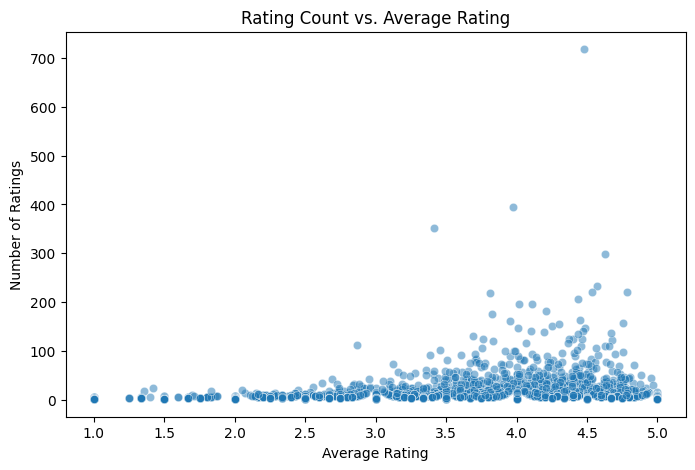

In [8]:
item_stats = electronic_data.groupby('ItemID').agg({'Rating': ['count', 'mean']})
item_stats.columns = ['rating_count', 'rating_mean']

plt.figure(figsize=(8, 5))
sns.scatterplot(x=item_stats['rating_mean'], 
                y=item_stats['rating_count'], 
                alpha=0.5)
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Rating Count vs. Average Rating")
plt.show()


In [9]:
reader = Reader(rating_scale=(1, 5))

In [10]:
ratings_df = Dataset.load_from_df(electronic_data[['UserID', 'ItemID', 'Rating']], reader)

In [11]:
trainset, testset = train_test_split(ratings_df, test_size=0.2)

In [12]:
trainset_full = ratings_df.build_full_trainset()

In [13]:
param_grid = {
    'n_factors': [50, 100],  
    'lr_all': [0.002, 0.005, 0.01],  
    'reg_all': [0.02, 0.05, 0.1]  
}

grid_search_cv = GridSearchCV(SVDpp, 
                              param_grid, 
                              n_jobs=-1, 
                              measures=['rmse', 'mae'], 
                              cv=3)
grid_search_cv.fit(ratings_df)

In [14]:
best_params = grid_search_cv.best_params['rmse']
print(best_params)


best_svdpp_model = SVDpp(n_factors=best_params['n_factors'], 
                         lr_all=best_params['lr_all'], 
                         reg_all=best_params['reg_all'])

{'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [15]:
trainset_full = ratings_df.build_full_trainset()
best_svdpp_model.fit(trainset_full)

In [16]:
all_items = electronic_data['ItemID'].unique()
items_reviewed_by_user = electronic_data[electronic_data['UserID'] == 'A3SRR8IB3NGHCG']['ItemID']
item_set = np.setdiff1d(all_items, items_reviewed_by_user)
testset = [['A3SRR8IB3NGHCG', item_id_val, 0] for item_id_val in item_set]
predictions = data = best_svdpp_model.test(testset)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.sort_values(by='est', ascending=False)
predictions_df.head(3)

,uid,iid,r_ui,est,details
4202,A3SRR8IB3NGHCG,B00006I53X,0,4.813553,{'was_impossible': False}
15579,A3SRR8IB3NGHCG,B000BMZHX2,0,4.770920,{'was_impossible': False}
405,A3SRR8IB3NGHCG,B00000JHWX,0,4.763902,{'was_impossible': False}


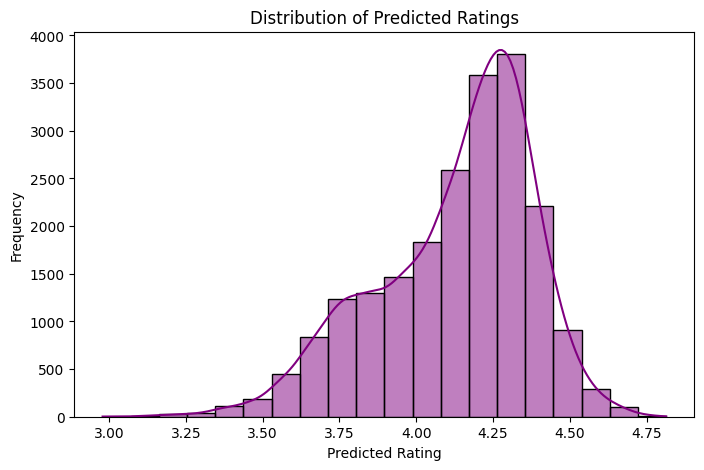

In [17]:
pred_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(8, 5))
sns.histplot(pred_ratings, bins=20, kde=True, color='purple')
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Ratings")
plt.show()

In [18]:
accuracy.rmse(predictions)

RMSE: 4.1345


4.134453528426321

In [19]:
ratings_df = Dataset.load_from_df(electronic_data[['UserID', 'ItemID', 'Rating']], 
                                  reader)
cross_validate(algo=best_svdpp_model, 
               data=ratings_df, 
               cv=5, 
               verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3580  1.3636  1.3486  1.3573  1.3639  1.3583  0.0056  
MAE (testset)     1.0845  1.0906  1.0789  1.0856  1.0920  1.0863  0.0047  
Fit time          1.08    1.21    1.12    1.13    1.04    1.12    0.06    
Test time         0.11    0.07    0.08    0.04    0.10    0.08    0.02    


{'test_rmse': array([1.35803211, 1.36359924, 1.34861258, 1.35727189, 1.36393177]),
 'test_mae': array([1.08452518, 1.09059004, 1.07886773, 1.08563743, 1.09195971]),
 'fit_time': (1.0778937339782715,
  1.2134008407592773,
  1.1179909706115723,
  1.1288416385650635,
  1.040809154510498),
 'test_time': (0.10994648933410645,
  0.07032465934753418,
  0.0796060562133789,
  0.04182004928588867,
  0.09703207015991211)}